In [1]:
%matplotlib notebook
from kd_tree_visualizer import * # визуализатор построения и поиска в kd-tree

# Пересечение прямоугольника с множеством прямоугольников

## Постановка задачи
Пусть дано множество прямоугольников - $P$ - стороны которых параллельны осям координат. Нужно эффективно отвечать на запросы следующего вида: для прямоугольника $q$ (его стороны также параллельны осям координат) определить, с какими прямоугольниками из $P$ он пересекается. 

## Идея решения
Разобъем все возможные случаи пересечения $q$ с некоторым прямоугольником $p \in P$ на три (необязательно непересекающихся) множества:

* Одна (или более) вершин $q$ лежат внутри прямоугольника $p$.

<img src="q_in_p.png" style="width: 400px; float: midle" />

Все такие случаи можно учесть, если для каждой вершины $q$ найти все прямоугольники, в которые она попадает. Таким образом, данный случай сводится к решению задачи о **нахождении всех прямоугольников, в которые попадает заданная точка**.

* Одна (или более) вершин $p$ лежат внутри прямоугольника запроса $q$.

<img src="p_in_q.png" style="width: 400px; float: midle" />

Все такие случаи можно учесть, если рассмотреть множество $T$ - точек, являющихся вершинами прямоугольников из $P$ и найти, какие точки из $T$ попадают в прямоугольник $q$. Таким образом, данный случай сводится к решению задачи о **нахождении всех точек, которые попадают в заданный прямоугольник**.

* Одна (или более) сторон $p$ пересекают (но не лежат концами) прямоугольник запроса $q$.

<img src="p_intersects_q.png" style="width: 400px; float: midle" />

Все такие случаи можно учесть, если рассмотреть множество $S$ - отрезков, которые являются сторонами прямоугольников из $P$ и найти, какие отрезки из $S$ пересекают (но не лежат концами) прямоугольник $q$. Таким образом, данный случай сводится к решению задачи о **нахождении всех отрезков, которые пересекают заданный прямоугольник** (задача рассмотрена в 4 билете).

**Ответом к задаче** будет объединение ответов к трем подзадачам.

### Нахождение множества точек, попадающих в прямоугольник запроса

Для начала быстро рассмотрим одномерный случай. Быстро выдавать множество точек, попадающих в отрезок, можно с помощью сбалансированного дерева поиска. (Примечание: можно и с помощью отсортированного массива и бинпоиска, но в такую структуру данных нельзя эффективно вставить новую точку).

Как это делать - очевидно: идем вглубь дерева, пока не встретим узел, разделяющий концы отрезка. После этого ищем каждый конец отрезка в отдельности и добавляем к ответу все поддеревья, лежащие справа (для левого конца) и слева (для правого конца) от пути.

Такое дерево можно построить за $O(n\log n)$, она будет занимать $O(n)$ памяти, запрос будет обработан за $O(\log n + k)$, где $k$ - величина ответа. Как расширить эту структуру на двумерный случай и добиться сопоставимых результатов?

## Способ 1. K-d tree

K-d дерево (short for **k-dimensional tree**) — статическая структура данных для хранения точек в k-мерном пространстве. Позволяет отвечать на запрос, какие точки лежат в данном прямоугольнике.
### Построение:
Строится это дерево следующим образом: разобьём все точки на плоскости вертикальной прямой так, чтобы слева (нестрого) и справа (строго) от неё было примерно поровну точек (для этого посчитаем медиану первых координат). Получим подмножества для левого и правого ребёнка. Далее построим для этих подмножеств деревья, но разбивать будем уже не вертикальной, а горизонтальной прямой (для этого посчитаем медиану вторых координат). И так далее (будем считать, что $k = 2$ (случай бОльших размерностей обрабатывается аналогично), поэтому на следующем уровне вновь будем разбивать вертикальными прямыми) пока в множестве больше 2-х точек.

<IPython.core.display.Javascript object>


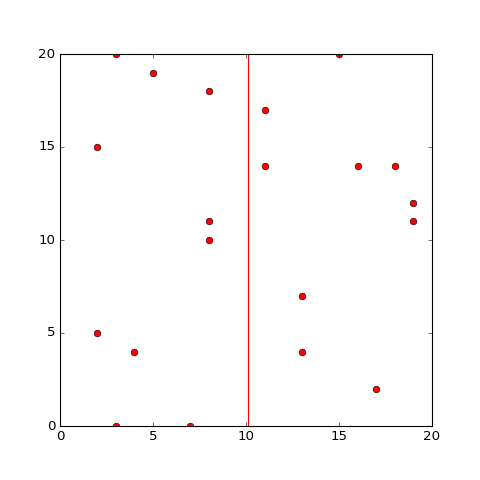

In [2]:
points = generatePoints(20, 20) # Генерирует массив из 20 точек, с координатами от 0 до 20. 

kd_tree_visualize_build(points) # Визуализация построения дерева до step шага. 
                                # Прямая, добавленная на текущем шаге, выделане красным.

##### Время построения: 
>*Построение выполняется за $O(n \log n)$*.

<br>$\triangleright$<br>
<div style="padding-left:40px"> 
Время построения обозначим $T(n)$. Поиск медианы можно сделать за линейное время, поэтому достаточно очевидно, что:

$T(n) = O(1)$ if $n = 1$.

$T(n) = O(n) + 2 \cdot T(n / 2)$, otherwise.

Решением этого является $T(n) = O(n \log n)$.

Также стоит отметить, что можно и не искать медиану за линейное время, а просто посортить все точки в самом начале и дальше использовать это. В реализации попроще, асимптотика та же.</div>
$\triangleleft$

##### Занимаемая память:
>*K-d дерево требует $O(n)$ памяти.*

<br>$\triangleright$<br>
<div style="padding-left:40px"> 
Высота дерева, очевидно, логарифмическая, а листьев всего $O(n)$. Поэтому будет $O(n)$ вершин, каждая занимает $O(1)$ памяти.</div>
$\triangleleft$

###  Запрос:

Пусть нам поступил какой-то прямоугольник $R$. Нужно вернуть все точки, которые в нём лежат. Будем это делать рекурсивно, получая на вход корень дерева и сам прямоугольник $R$. Обозначим область, соответствующую вершине $v$, как $\operatorname{region(v)}$. Она будет прямоугольником, одна или более границ которого могут быть на бесконечности. $\operatorname{region(v)}$ можно явно хранить в узлах, записав при построении, или же считать при рекурсивном спуске. Если корень дерева является листом, то просто проверяем одну точку и при необходимости репортим её. Если нет, то смотрим пересекают ли регионы детей прямоугольник $R$. Если да, то запускаемся рекурсивно от такого ребёнка. При этом, если регион полностью содержится в $R$, то можно репортить сразу все точки из него. Тем самым мы, очевидно, вернём все нужные точки и только их.

###### Визуализотор:

Тёмно-синяя обасть - прямоугольник R

Красные области - регионы, полностью входящие в R

Светло-синие области - листья, до которых дошел наш алгоритм

<IPython.core.display.Javascript object>


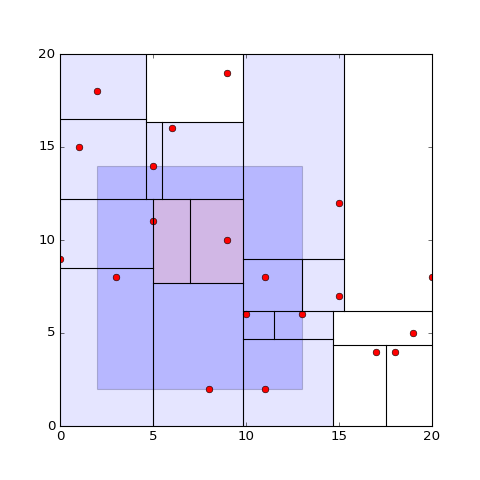

[3, 8, 8, 2, [5, 11], [9, 10], 5, 14, 11, 2, 10, 6, 13, 6, 11, 8]


In [3]:
R = [2, 2, 13, 14]                     # запрос -- тёмно-синяя обасть
points = generatePoints(20, 20)        # точки  
kd_tree_search_visualize(R, points)    # красные области - регионы, полностью входящие в R
                                       # светло-синие области - листья kd-tree, в которых мы ищем точки

##### Время работы:
>*Перечисление точек в прямоугольнике выполняется за $O(\sqrt n + ans)$, где $ans$ — размер ответа.*

<br>$\triangleright$<br><div style="padding-left:40px"> 
Сперва заметим, что все ReportSubtree суммарно выполняются за O(ans). Поэтому достаточно доказать оценку для числа рекурсивных вызовов. А рекурсивные вызовы выполняются только для тех вершин, регионы которых пересекают R, но не содержатся в нём. Такие регионы обязательно пересекают хотя бы одну (axis-parallel) сторону заданного прямоугольника. Оценим количество регионов, которые могут пересекаться произвольной вертикальной прямой. Для горизонтальной прямой это будет аналогично.

Обозначим максимально возможное количество регионов, пересекаемых какой-либо вертикальной прямой, в дереве для $n$ точек, у которого первое разбиение делается вертикальной прямой, как $Q(n)$. Рассмотрим произвольную вертикальную прямую $l$. Она будет пересекать регион корня и какого-то одного из его детей (например, левого). При этом ни один из регионов в другом (правом) поддереве пересекать она не может. Левая половина разбита ещё на 2 части горизонтальной прямой, в каждой из них примерно $n / 4$ вершин, и они хранятся в поддереве, у которого первое разбиение делается вертикальной прямой. Это даёт нам следующее соотношение:

$Q(n) = O(1)$ if $n = 1$.
$Q(n) = 2 + 2 \cdot Q(n / 4)$, otherwise.

Глубина дерева рекурсии равна: $\log_4 n = \frac{1}{2}\log_2 n$

Следовательно, $Q(n) = O(2^{\frac{1}{2}\log_2 n}) = O(\sqrt n)$ является решением. Принимая во внимание всё, что писалось выше, получаем требуемое.</div>
$\triangleleft$

## Способ 2. Range tree

### Построение:
<img src="range_tree.png" style="width: 400px; float: right" />
Дадим следующее рекурсивное определение **range-tree**:
* Одномерное **range-tree** — просто дерево поиска, описанное выше.
* $d$-мерное **range-tree** — дерево поиска (по первой координате $X_1$), аналогичное описанному выше, но в каждой вершине дополнительно хранящее $d-1$-мерное **range-tree** (по остальным координатам $X_2 \times \cdots \times X_d$) для множества элементов, являющихся листами поддерева этой вершины.

### Запрос:
Запрос на выдачу точек, принадлежащих некому прямоугольнику $R$, выполняется следующим образом:
Выполнить описанную в постоновке задачипроцедуру поиска элементов отрезка для проекции прямоугольника запроса на $X_1$.

При добавлении поддерева к ответу:
* Если текущая координата - последняя, выдать все листы поддерева в качестве ответа
* Если текущая координата - не последняя, перейти к сохраненному в корне поддерева range-tree по следующим координатам и повторить тот же алгоритм.

Таким образом, алгоритм сначала найдет по первой координате некоторый набор поддеревьев, потом выполнит поиск по второй координате внутри этих поддеревьев, и так далее.

##### Время работы:
>*Перечисление точек в прямоугольнике выполняется за $O(\log^d n + ans)$, где ans - количество точек ответа.*

<br>$\triangleright$<br><div style="padding-left:40px"> 
Фаза алгоритма, обрабатывающая одну координату, может выдать $O(\log n)$ поддеревьев высотой $O(\log n)$, каждое из которых будет обработано фазой по следующей координате, и т.д. Таким образом, время запроса - $O(\log^d n + ans)$
</div>
$\triangleleft$

##### Занимаемая память
>*Range-tree дерево требует $O(n)$ памяти.*

<br>$\triangleright$<br><div style="padding-left:40px"> 
Докажем по индукции оценку в $O(n \log^{d-1} n)$ для потребляемой памяти для структуры range-tree.
* $d = 1$: в одномерном случае range-tree является обычным деревом, оценка в $O(n \log^0 n) = O(n)$ очевидна.
* $d > 1$: очевидно, что основным слагаемым в оценке потребляемой памяти будут не сами хранимые элементы, а range-tree меньшей размерности, хранимые в каждой вершине, которые по индукционному предположению занимают $O(n \log^{d-2} n)$ памяти. Просуммируем размеры этих range-tree (суммирование по расстоянию до вершины от корня): $\sum_{k=1}^{\log n} 2^k O(\frac{n}{2^k} \log^{d-2} \frac{n}{2^k}) = \sum_{k=1}^{\log n} O(n \log^{d-2} n) = O(n \log^{d-1} n)$. 
</div>
$\triangleleft$

### Fractional cascading:

Техника **fractional cascading** позволяет снизить ассимптотику запроса в **range-tree** до $O(\log^{d - 1} n + k)$.

##### Суть:

Рассмотрим две упорядоченных последовательности $S_1$ и $S_2$, причем $S_2 \subset S_1$. Пусть стоит задача выдать элементы некоторого отрезка, принадлежащие этим последовательностям. Очевидно, это можно сделать бинпоиском для каждой последовательности отдельно за $O(\log n + k)$, где $k$ - размер ответа; тем не менее, это решение никак не использует тот факт, что $S_2 \subset S_1$.
Теперь, зная, что $S_2 \subset S_1$, для каждого элемента $a_1 \in S_1$ будем хранить ссылку на минимальный элемент $a_2 \in S_2$, такой, что $a_2 \geq a_1$. В таком случае мы можем избавитсья от двоичного поиске по $S_2$: после поиска по $S_1$, мы можем перейти по ссылке, запомненной для первого элемента ответа из $S_1$, и выдавать элементы из $S_2$, пока они лежат в отрезке запроса. Таким образом, запрос для второй последовательности может быть осуществлен за $O(1 + k)$.

### Layered range-tree

Рассмотрим $d$-мерное **range-tree** и запрос, выполненный до ($d$-1)-ой координаты. На последнем шаге мы выбрали набор вершин, поддеревья которых будут обработаны следующим шагом алгоритма (уже по последней координате). Всегда существует поддерево, содержащее в себе все эти вершины (корнем этого поддерева будет последняя общая вершина в путях от корня дерева к левому и правому концам отрезка запроса). Корень этого поддерева назовем $v_{split}$.
Вместо хранения деревьев, мы будем хранить массивы вершин, отсортированные по последней координате. Заметим, что множества вершин, соответствующие правому и левому детям некоторой вершины, являются подмножествами множества вершин, соответствующему их родителю. Используем этот факт, чтобы применить **fractional cascading**. В массивах вместе с вершинами будем хранить ссылку на минимальный элемент массива в левом ребенке, больший или равный текущему элементу массива; аналогично будем хранить ссылки на элементы массива в правом ребенке текущей вершины. **Range-tree** с такой оптимизацией называют **layered range-tree**.
Для осуществления запроса найдем двоичным поиском в массиве, хранящемся в $v_{split}$, левую границу множества элементов, лежащих в отрезке запроса. Далее, при спуске по дереву (при поиске по предпоследней координате), мы можем поддерживать левую границу текущего поддерева (границу по последней координате), используя сохраненные ссылки. При обработке поддерева по предпоследней координате, используя сохраненный в корне поддерева массив вершин и ссылку на левую границу ответа, мы можем выдать ответ за $O(1 + k_v)$, где $k_v$ - размер ответа в поддереве вершины v.
Таким образом, мы избавились от поиска по дереву на последнем уровне **range-tree**, сократив врем работы до $O(\log^{d-1} n + k)$.